Wilfredo Gallegos 20399


Paulo Sánchez 21401

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.tsa as tsa
import statsmodels as sm
from datetime import datetime
import os
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.metrics import mean_squared_error
from operator import concat
from sklearn.model_selection import train_test_split


In [3]:
#Data Frame importaciones
dfi=pd.read_csv("ImportacionDS.csv",sep=";")
#Data frame consumo #Archivo consumo
dfc=pd.read_csv("ConsumoDS.csv",sep=";")
#Data Frame precios 
df_p=pd.read_csv("PreciosMensuales.csv",sep=";")
#Seleccionando las columnas por usar
df_imp=dfi[["Fecha","Diesel bajo azufre","Gas licuado de petroleo","Gasolina regular","Gasolina superior"]]
df_con=dfc[["Fecha","Diesel bajo azufre","Gas licuado de petroleo","Gasolina regular","Gasolina superior"]]
df_pre=df_p[["Fecha","Diesel","Gas licuado","Gasolina regular","Gasolina superior"]]


### Preparando la serie de tiempo para trabajar con ella desde del 2018 hasta la actualidad para los tres casos 

In [4]:
meses = {
    'ene': '01', 'feb': '02', 'mar': '03', 'abr': '04', 'may': '05', 'jun': '06',
    'jul': '07', 'ago': '08', 'sep': '09', 'oct': '10', 'nov': '11', 'dic': '12'
}

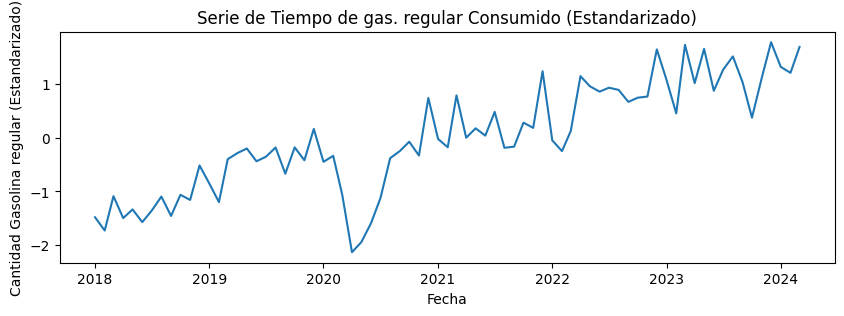

             Tipo     Valor      Fecha
0  Lectura Máxima  1.783135 2023-12-01
1  Lectura Mínima -2.133891 2020-04-01


In [5]:
cons_regular = df_con[['Fecha', 'Gasolina regular']].copy()

# Reemplazar abreviaturas de meses por números
cons_regular['Fecha'] = cons_regular['Fecha'].str.lower().replace(meses, regex=True)

# Convertir a datetime
cons_regular['Fecha'] = pd.to_datetime(cons_regular['Fecha'], format='%m/%Y')

# Limpiar y convertir la columna 'Gasolina regular'
cons_regular['Gasolina regular'] = cons_regular['Gasolina regular'].str.replace(',', '')
cons_regular['Gasolina regular'] = pd.to_numeric(cons_regular['Gasolina regular'], errors='raise')

start_date = '2018-01-01'
end_date = '2024-03-01'
cons_regular = cons_regular.loc[cons_regular['Fecha'] >= start_date]
cons_regular = cons_regular.loc[cons_regular['Fecha'] <= end_date]

# Standardize the 'Gasolina regular' column
scaler = StandardScaler()
cons_regular['Gasolina regular'] = scaler.fit_transform(cons_regular[['Gasolina regular']])

# Graficar
plt.figure(figsize=(10, 3))
plt.plot(cons_regular['Fecha'], cons_regular['Gasolina regular'])
plt.title('Serie de Tiempo de gas. regular Consumido (Estandarizado)')
plt.xlabel('Fecha')
plt.ylabel('Cantidad Gasolina regular (Estandarizado)')
# plt.grid(True)
plt.show()

# Encontrar el valor máximo y mínimo
max_value = cons_regular['Gasolina regular'].max()
min_value = cons_regular['Gasolina regular'].min()

# Encontrar las fechas correspondientes al valor máximo y mínimo
max_date = cons_regular[cons_regular['Gasolina regular'] == max_value]['Fecha'].values[0]
min_date = cons_regular[cons_regular['Gasolina regular'] == min_value]['Fecha'].values[0]

# Crear la tabla
summary_table = pd.DataFrame({
    'Tipo': ['Lectura Máxima', 'Lectura Mínima'],
    'Valor': [max_value, min_value],
    'Fecha': [max_date, min_date]
})

# Mostrar la tabla
print(summary_table)

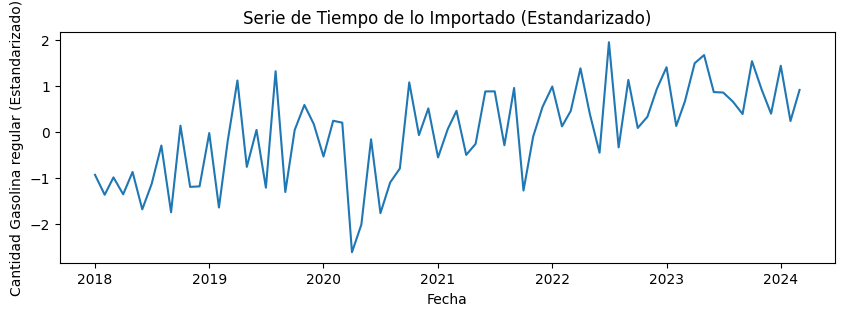

             Tipo     Valor      Fecha
0  Lectura Máxima  1.954351 2022-07-01
1  Lectura Mínima -2.617137 2020-04-01


In [6]:
# Crear una copia del DataFrame para trabajar con él
imp_regular = df_imp[['Fecha', 'Gasolina regular']].copy()

# Reemplazar abreviaturas de meses por números
imp_regular['Fecha'] = imp_regular['Fecha'].str.lower().replace(meses, regex=True)

# Convertir a datetime
imp_regular['Fecha'] = pd.to_datetime(imp_regular['Fecha'], format='%m/%Y')

# Limpiar y convertir la columna 'Gasolina regular'
imp_regular['Gasolina regular'] = imp_regular['Gasolina regular'].str.replace(',', '')
imp_regular['Gasolina regular'] = pd.to_numeric(imp_regular['Gasolina regular'], errors='raise')

start_date = '2018-01-01'
end_date = '2024-03-01'
imp_regular = imp_regular.loc[imp_regular['Fecha'] >= start_date]
imp_regular = imp_regular.loc[imp_regular['Fecha'] <= end_date]

# Standardize the 'Gasolina regular' column
scaler = StandardScaler()
imp_regular['Gasolina regular'] = scaler.fit_transform(imp_regular[['Gasolina regular']])

# Graficar
plt.figure(figsize=(10, 3))
plt.plot(imp_regular['Fecha'], imp_regular['Gasolina regular'])
plt.title('Serie de Tiempo de lo Importado (Estandarizado)')
plt.xlabel('Fecha')
plt.ylabel('Cantidad Gasolina regular (Estandarizado)')
# plt.grid(True)
plt.show()

# Encontrar el valor máximo y mínimo
max_value = imp_regular['Gasolina regular'].max()
min_value = imp_regular['Gasolina regular'].min()

# Encontrar las fechas correspondientes al valor máximo y mínimo
max_date = imp_regular[imp_regular['Gasolina regular'] == max_value]['Fecha'].values[0]
min_date = imp_regular[imp_regular['Gasolina regular'] == min_value]['Fecha'].values[0]

# Crear la tabla
summary_table = pd.DataFrame({
    'Tipo': ['Lectura Máxima', 'Lectura Mínima'],
    'Valor': [max_value, min_value],
    'Fecha': [max_date, min_date]
})

# Mostrar la tabla
print(summary_table)

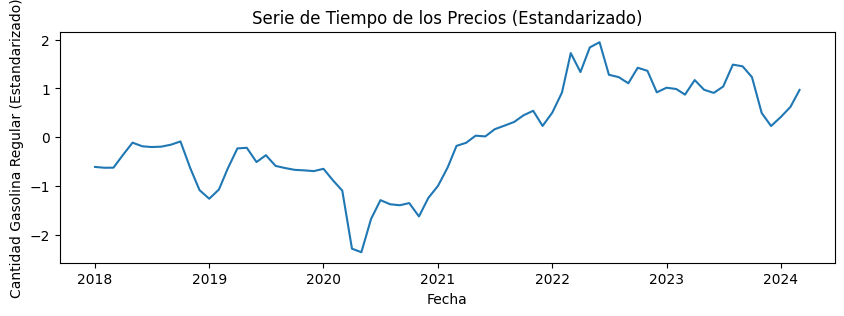

             Tipo     Valor      Fecha
0  Lectura Máxima  1.945971 2022-06-01
1  Lectura Mínima -2.352689 2020-05-01


In [7]:
# Crear una copia del DataFrame para trabajar con él
pre_regular = df_pre[['Fecha', 'Gasolina regular']].copy()

# Reemplazar abreviaturas de meses por números
pre_regular['Fecha'] = pre_regular['Fecha'].str.lower().replace(meses, regex=True)

# Convertir a datetime con el formato 'mm-yy'
pre_regular['Fecha'] = pd.to_datetime(pre_regular['Fecha'], format='%m-%y')

# Filtrar por el rango de fechas
start_date = '2018-01-01'
end_date = '2024-03-01'
pre_regular = pre_regular.loc[pre_regular['Fecha'] >= start_date]
pre_regular = pre_regular.loc[pre_regular['Fecha'] <= end_date]

# Aplicar la transformación logarítmica
pre_regular['Gasolina regular'] = np.log(pre_regular['Gasolina regular'] + 1)

# Standardize the 'Gasolina regular' column
scaler = StandardScaler()
pre_regular['Gasolina regular'] = scaler.fit_transform(pre_regular[['Gasolina regular']])

# Graficar
plt.figure(figsize=(10, 3))
plt.plot(pre_regular["Fecha"], pre_regular["Gasolina regular"])
plt.title('Serie de Tiempo de los Precios (Estandarizado)')
plt.xlabel('Fecha')
plt.ylabel('Cantidad Gasolina Regular (Estandarizado)')
# plt.grid(True)
plt.show()

# Encontrar el valor máximo y mínimo
max_value = pre_regular['Gasolina regular'].max()
min_value = pre_regular['Gasolina regular'].min()

# Encontrar las fechas correspondientes al valor máximo y mínimo
max_date = pre_regular[pre_regular['Gasolina regular'] == max_value]['Fecha'].values[0]
min_date = pre_regular[pre_regular['Gasolina regular'] == min_value]['Fecha'].values[0]

# Crear la tabla
summary_table = pd.DataFrame({
    'Tipo': ['Lectura Máxima', 'Lectura Mínima'],
    'Valor': [max_value, min_value],
    'Fecha': [max_date, min_date]
})

# Mostrar la tabla
print(summary_table)

Para mantener estacionalidad se transformo el precio de la Gasolina Regular para que se acoplara y mantuviera la varianza constante para los modelos. 

## Modelo LSTM

### Consumo Gasolina Regular 

#### Primer Modelo

Separando los datos para entrenamiento y para prueba, en este caso se va partir 80% de entrenamiento,20% de validación

In [10]:
def create_sequences(data, time_steps=1):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:(i + time_steps)])
        y.append(data[i + time_steps])
    return np.array(X), np.array(y)

Se tiene que generar una funcion para preparar los datos para LSTM

In [13]:

# Create sequences
# Definir el número de pasos de tiempo
time_steps = 12  # Puedes ajustar este valor

# Crear secuencias
X, y = create_sequences(cons_regular['Gasolina regular'].values, time_steps)

# Dividir los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Redimensionar los datos para que sean compatibles con LSTM
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

  

Creando el modelo LSTM

In [14]:
# Construir el modelo LSTM
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(50))
model.add(Dense(1))

# Compilar el modelo
model.compile(optimizer='adam', loss='mean_squared_error')

# Entrenar el modelo
history = model.fit(X_train, y_train, epochs=20, batch_size=16, validation_data=(X_test, y_test))


c:\Users\raule\anaconda3\envs\numpy_env\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 375ms/step - loss: 0.5911 - val_loss: 1.2597
Epoch 2/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.4877 - val_loss: 0.7547
Epoch 3/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.4758 - val_loss: 0.4567
Epoch 4/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.4538 - val_loss: 0.3078
Epoch 5/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.4199 - val_loss: 0.1945
Epoch 6/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.4227 - val_loss: 0.1814
Epoch 7/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.3479 - val_loss: 0.2318
Epoch 8/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.3880 - val_loss: 0.3137
Epoch 9/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.3170 - val_loss: 0.3577
Epoch 10/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.4235 - val_loss: 0.3084
Epoch 11/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.3706 - val_loss: 0.2875
Epoch 12/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.3978 - val_loss: 0.3845


Evaluando y prediciendo el modelo

Train Loss: 0.33933907747268677
Test Loss: 0.36474162340164185
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 613ms/step


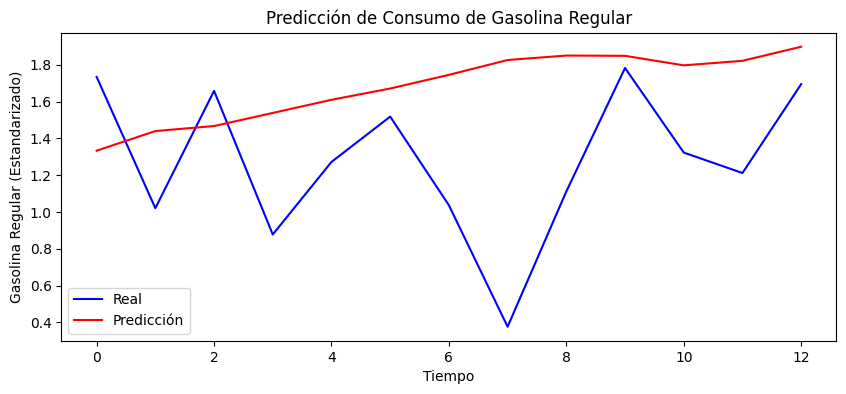

In [15]:
# Evaluar el modelo
train_loss = model.evaluate(X_train, y_train, verbose=0)
test_loss = model.evaluate(X_test, y_test, verbose=0)
print(f'Train Loss: {train_loss}')
print(f'Test Loss: {test_loss}')

# Predecir
predictions = model.predict(X_test)

# Graficar resultados
plt.figure(figsize=(10, 4))
plt.plot(range(len(y_test)), y_test, color='blue', label='Real')
plt.plot(range(len(predictions)), predictions, color='red', label='Predicción')
plt.title('Predicción de Consumo de Gasolina Regular')
plt.xlabel('Tiempo')
plt.ylabel('Gasolina Regular (Estandarizado)')
plt.legend()
plt.show()

### Segundo Modelo

Definiendo las secuencias

In [17]:
# Create sequences
# Definir el número de pasos de tiempo
time_steps = 12  # Puedes ajustar este valor

# Crear secuencias
X, y = create_sequences(cons_regular['Gasolina regular'].values, time_steps)

# Dividir los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=False)

# Redimensionar los datos para que sean compatibles con LSTM
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

Construyendo el modelo

In [18]:
# Construir el modelo LSTM
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(50))
model.add(Dense(1))

# Compilar el modelo
model.compile(optimizer='adam', loss='mean_squared_error')

# Entrenar el modelo
history = model.fit(X_train, y_train, epochs=20, batch_size=16, validation_data=(X_test, y_test))

Epoch 1/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 307ms/step - loss: 0.6561 - val_loss: 0.6290
Epoch 2/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 0.4876 - val_loss: 0.1939
Epoch 3/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 0.4440 - val_loss: 0.2962
Epoch 4/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 0.3269 - val_loss: 0.5824
Epoch 5/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.3581 - val_loss: 0.4501
Epoch 6/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.3298 - val_loss: 0.2365
Epoch 7/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - loss: 0.4110 - val_loss: 0.2070
Epoch 8/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.4168 - val_loss: 0.2326
Epoch 9/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.3696 - val_loss: 0.3309
Epoch 10/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.2414 - val_loss: 0.4070
Epoch 11/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.2593 - val_loss: 0.3871
Epoch 12/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.2692 - val_loss: 0.3496


Evaluacion y graficacion de modelo

Train Loss: 0.28957507014274597
Test Loss: 0.33394500613212585
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 405ms/step


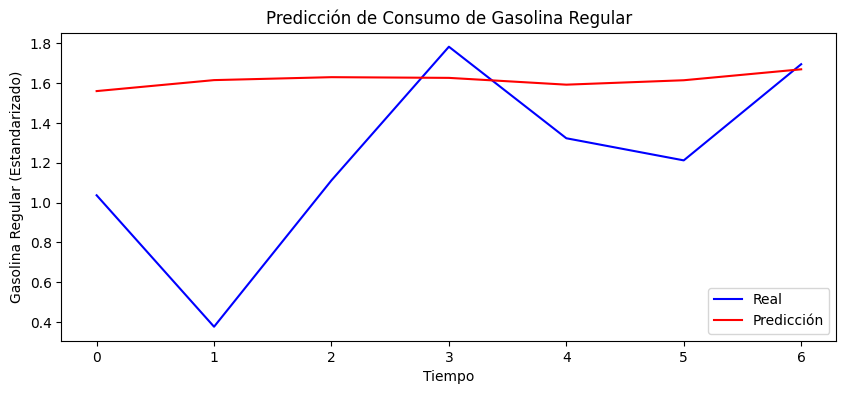

In [19]:
# Evaluar el modelo
train_loss = model.evaluate(X_train, y_train, verbose=0)
test_loss = model.evaluate(X_test, y_test, verbose=0)
print(f'Train Loss: {train_loss}')
print(f'Test Loss: {test_loss}')

# Predecir
predictions = model.predict(X_test)

# Graficar resultados
plt.figure(figsize=(10, 4))
plt.plot(range(len(y_test)), y_test, color='blue', label='Real')
plt.plot(range(len(predictions)), predictions, color='red', label='Predicción')
plt.title('Predicción de Consumo de Gasolina Regular')
plt.xlabel('Tiempo')
plt.ylabel('Gasolina Regular (Estandarizado)')
plt.legend()
plt.show()

## Importacion de Gasolina Regular 

### Primer Modelo

Definiendo las secuencias

In [21]:
# Create sequences
# Definir el número de pasos de tiempo
time_steps = 12  # Puedes ajustar este valor

# Crear secuencias
X, y = create_sequences(imp_regular['Gasolina regular'].values, time_steps)

# Dividir los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Redimensionar los datos para que sean compatibles con LSTM
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

Construyendo modelo

In [22]:
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(50))
model.add(Dense(1))

# Compilar el modelo
model.compile(optimizer='adam', loss='mean_squared_error')

# Entrenar el modelo
history = model.fit(X_train, y_train, epochs=20, batch_size=16, validation_data=(X_test, y_test))

Epoch 1/20


c:\Users\raule\anaconda3\envs\numpy_env\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 275ms/step - loss: 0.8660 - val_loss: 0.7526
Epoch 2/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.7409 - val_loss: 0.5676
Epoch 3/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.8332 - val_loss: 0.4290
Epoch 4/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 0.8787 - val_loss: 0.4142
Epoch 5/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.9092 - val_loss: 0.3770
Epoch 6/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.8804 - val_loss: 0.3265
Epoch 7/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.8252 - val_loss: 0.2953
Epoch 8/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.8212 - val_loss: 0.2770
Epoch 9/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.7472 - val_loss: 0.3023
Epoch 10/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.8326 - val_loss: 0.3218
Epoch 11/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.7980 - val_loss: 0.3624
Epoch 12/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.7856 - val_loss: 0.4024
Epoch 13/20

Evaluando y prediciendo el modelo

Train Loss: 0.8066180944442749
Test Loss: 0.29084137082099915
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 585ms/step


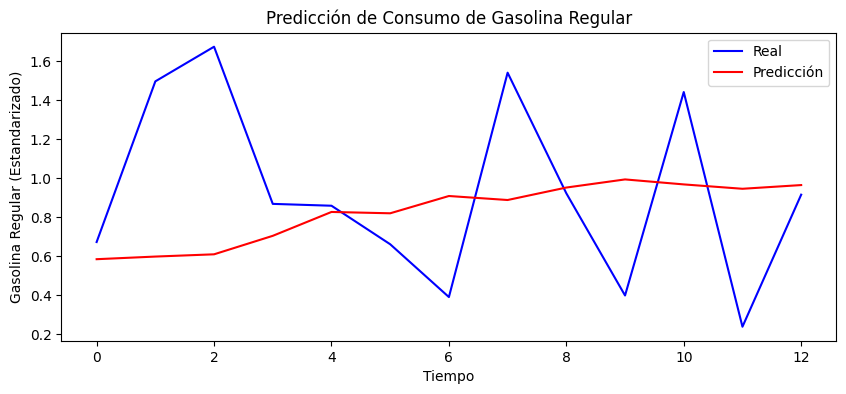

In [23]:
train_loss = model.evaluate(X_train, y_train, verbose=0)
test_loss = model.evaluate(X_test, y_test, verbose=0)
print(f'Train Loss: {train_loss}')
print(f'Test Loss: {test_loss}')

# Predecir
predictions = model.predict(X_test)

# Graficar resultados
plt.figure(figsize=(10, 4))
plt.plot(range(len(y_test)), y_test, color='blue', label='Real')
plt.plot(range(len(predictions)), predictions, color='red', label='Predicción')
plt.title('Predicción de Importacion de Gasolina Regular')
plt.xlabel('Tiempo')
plt.ylabel('Gasolina Regular (Estandarizado)')
plt.legend()
plt.show()

### Segundo Modelo

In [24]:
# Create sequences
# Definir el número de pasos de tiempo
time_steps = 12  # Puedes ajustar este valor

# Crear secuencias
X, y = create_sequences(imp_regular['Gasolina regular'].values, time_steps)

# Dividir los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=False)

# Redimensionar los datos para que sean compatibles con LSTM
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

Construyendo modelo

In [25]:
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(50))
model.add(Dense(1))

# Compilar el modelo
model.compile(optimizer='adam', loss='mean_squared_error')

# Entrenar el modelo
history = model.fit(X_train, y_train, epochs=20, batch_size=16, validation_data=(X_test, y_test))

Epoch 1/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 9s 396ms/step - loss: 0.7533 - val_loss: 0.4878
Epoch 2/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.7975 - val_loss: 0.2668
Epoch 3/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.7813 - val_loss: 0.2553
Epoch 4/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.8936 - val_loss: 0.3407
Epoch 5/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.8162 - val_loss: 0.4377
Epoch 6/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.7789 - val_loss: 0.4744
Epoch 7/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.8336 - val_loss: 0.4426
Epoch 8/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.7938 - val_loss: 0.3672
Epoch 9/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 0.7719 - val_loss: 0.3923
Epoch 10/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.7406 - val_loss: 0.4255
Epoch 11/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.7455 - val_loss: 0.4279
Epoch 12/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.7100 - val_loss: 0.3651


Train Loss: 0.7395185828208923
Test Loss: 0.4995606243610382
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 678ms/step


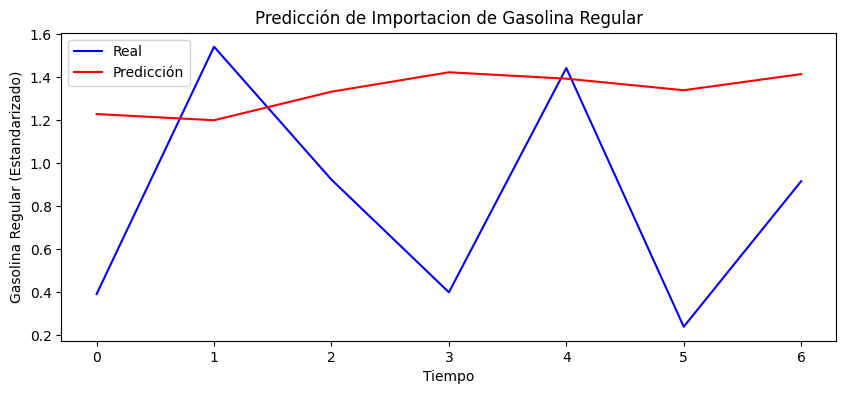

In [26]:
train_loss = model.evaluate(X_train, y_train, verbose=0)
test_loss = model.evaluate(X_test, y_test, verbose=0)
print(f'Train Loss: {train_loss}')
print(f'Test Loss: {test_loss}')

# Predecir
predictions = model.predict(X_test)

# Graficar resultados
plt.figure(figsize=(10, 4))
plt.plot(range(len(y_test)), y_test, color='blue', label='Real')
plt.plot(range(len(predictions)), predictions, color='red', label='Predicción')
plt.title('Predicción de Importacion de Gasolina Regular')
plt.xlabel('Tiempo')
plt.ylabel('Gasolina Regular (Estandarizado)')
plt.legend()
plt.show()

## Precio Gasolina Regular

### Primer modelo

In [35]:
# Create sequences
# Definir el número de pasos de tiempo
time_steps = 12  # Puedes ajustar este valor

# Crear secuencias
X, y = create_sequences(pre_regular['Gasolina regular'].values, time_steps)

# Dividir los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Redimensionar los datos para que sean compatibles con LSTM
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [36]:
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(50))
model.add(Dense(1))

# Compilar el modelo
model.compile(optimizer='adam', loss='mean_squared_error')

# Entrenar el modelo
history = model.fit(X_train, y_train, epochs=20, batch_size=16, validation_data=(X_test, y_test))

Epoch 1/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 11s 494ms/step - loss: 0.9613 - val_loss: 0.3169
Epoch 2/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.5722 - val_loss: 0.1382
Epoch 3/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.6403 - val_loss: 0.1824
Epoch 4/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.5438 - val_loss: 0.2594
Epoch 5/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 0.4800 - val_loss: 0.3572
Epoch 6/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.4197 - val_loss: 0.4063
Epoch 7/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.3580 - val_loss: 0.4503
Epoch 8/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.3706 - val_loss: 0.4230
Epoch 9/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.3707 - val_loss: 0.3531
Epoch 10/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.3961 - val_loss: 0.2922
Epoch 11/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.3808 - val_loss: 0.2489
Epoch 12/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.4079 - val_loss: 0.2244

Train Loss: 0.24510756134986877
Test Loss: 0.15557946264743805
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 543ms/step


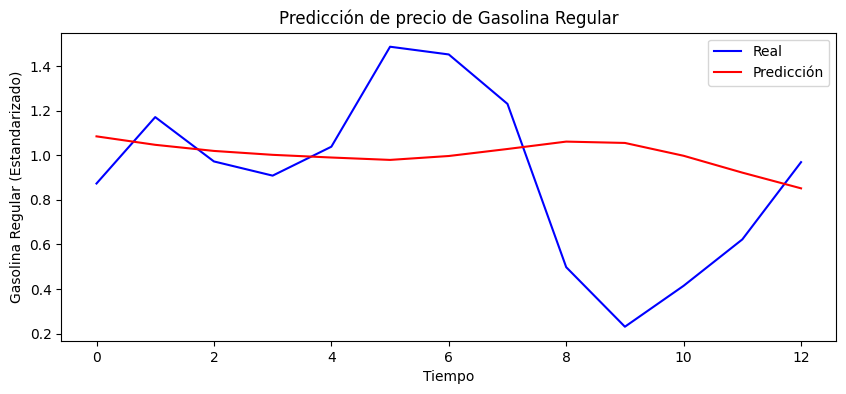

In [37]:
train_loss = model.evaluate(X_train, y_train, verbose=0)
test_loss = model.evaluate(X_test, y_test, verbose=0)
print(f'Train Loss: {train_loss}')
print(f'Test Loss: {test_loss}')

# Predecir
predictions = model.predict(X_test)

# Graficar resultados
plt.figure(figsize=(10, 4))
plt.plot(range(len(y_test)), y_test, color='blue', label='Real')
plt.plot(range(len(predictions)), predictions, color='red', label='Predicción')
plt.title('Predicción de precio de Gasolina Regular')
plt.xlabel('Tiempo')
plt.ylabel('Gasolina Regular (Estandarizado)')
plt.legend()
plt.show()

### Segundo Modelo

In [38]:
# Create sequences
# Definir el número de pasos de tiempo
time_steps = 12  # Puedes ajustar este valor

# Crear secuencias
X, y = create_sequences(pre_regular['Gasolina regular'].values, time_steps)

# Dividir los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)

# Redimensionar los datos para que sean compatibles con LSTM
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [39]:
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(50))
model.add(Dense(1))

# Compilar el modelo
model.compile(optimizer='adam', loss='mean_squared_error')

# Entrenar el modelo
history = model.fit(X_train, y_train, epochs=20, batch_size=16, validation_data=(X_test, y_test))

Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 9s 607ms/step - loss: 1.0594 - val_loss: 0.7162
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 0.9792 - val_loss: 0.4564
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - loss: 0.7853 - val_loss: 0.2652
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - loss: 0.7088 - val_loss: 0.1585
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - loss: 0.7719 - val_loss: 0.1267
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - loss: 0.6474 - val_loss: 0.1143
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - loss: 0.5606 - val_loss: 0.1177
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - loss: 0.5809 - val_loss: 0.1512
Epoch 9/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.4638 - val_loss: 0.2357
Epoch 10/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - loss: 0.4611 - val_loss: 0.3833
Epoch 11/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.4826 - val_loss: 0.6625
Epoch 12/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.4424 - val_loss: 1.0661


Train Loss: 0.268466979265213
Test Loss: 1.835665225982666
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 620ms/step


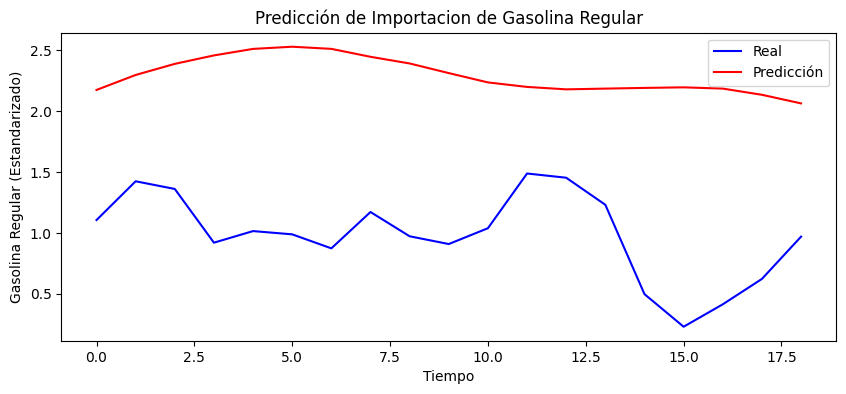

In [40]:
train_loss = model.evaluate(X_train, y_train, verbose=0)
test_loss = model.evaluate(X_test, y_test, verbose=0)
print(f'Train Loss: {train_loss}')
print(f'Test Loss: {test_loss}')

# Predecir
predictions = model.predict(X_test)

# Graficar resultados
plt.figure(figsize=(10, 4))
plt.plot(range(len(y_test)), y_test, color='blue', label='Real')
plt.plot(range(len(predictions)), predictions, color='red', label='Predicción')
plt.title('Predicción de Importacion de Gasolina Regular')
plt.xlabel('Tiempo')
plt.ylabel('Gasolina Regular (Estandarizado)')
plt.legend()
plt.show()

# Mejora de parametros 

## Consumo de Gasolina Regular